# Final Project - Reinforcements Learning

---
<br>

### Name and ID:
Student: Aviv Ples 318357233
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [1]:
%%capture
!apt-get update
!apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym==0.22
!pip install pygame
!apt-get install python-opengl -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym_sokoban
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip

!pip install mlflow==2.5.0 dagshub opencv-python

# Imports

In [2]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time

import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import pickle
import imageio
from base64 import b64encode

import cv2
from IPython.display import clear_output

In [3]:
import warnings
warnings.filterwarnings("ignore")
%autosave 5

Autosaving every 5 seconds


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [4]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [5]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

Function - given an environment it will return the indexes position and boxes locations

In [6]:
#@markdown Enter the DAGsHub repository owner name:
DAGSHUB_REPO_OWNER= "aviv.ples" #@param {type:"string"}

#@markdown Enter the DAGsHub repository name:
DAGSHUB_REPO_NAME= "sokoban-rl" #@param {type:"string"}

#@markdown Enter the username of your DAGsHub account:
DAGSHUB_USER_NAME = "aviv.ples" #@param {type:"string"}

DAGSHUB_TOKEN = "eb1587fdb4b2ef917e728f506d8bc187a67d1c93"

In [7]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

In [8]:
# MLFLOW

import mlflow
import os

os.environ['MLFLOW_TRACKING_USERNAME'] = DAGSHUB_USER_NAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = DAGSHUB_TOKEN
os.environ['MLFLOW_TRACKING_URI'] = f'https://dagshub.com/{DAGSHUB_REPO_OWNER}/{DAGSHUB_REPO_NAME}.mlflow'

print(os.getenv('MLFLOW_TRACKING_URI'))

https://dagshub.com/aviv.ples/sokoban-rl.mlflow


# Functions

## Pre-processing

Set the PyTorch device to either "cuda" if GPU is available, or CPU otherwise. If you GPU is available, using it can significantly speed up the computations required for training deep neural networks.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The replay memory buffer is used to store the experiences of an agent while it runs within the env. We will use the buffer sampling transitions from the it and using them to update the network's parameters during the training.

In [10]:
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1
        if left >= len(self.tree):
            return idx
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total_priority(self):
        return self.tree[0]

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write = (self.write + 1) % self.capacity

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[dataIdx])


In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory:
    def __init__(self, capacity, frame_history_len=4, alpha=0.6, beta=0.4):
        self.alpha = alpha
        self.beta = beta
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.e = 0.01
        self.a = 0.6
        self.frame_history_len = frame_history_len
        self.obs = None
        self.action = None
        self.reward = None
        self.done = None
        self.next_idx = 0
        self.num_in_buffer = 0

    def push(self, state, action, next_state, reward):
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        if max_priority == 0:
            max_priority = 1
        frame_idx = self.store_frame(state)
        self.store_effect(frame_idx, action, reward, False)
        self.tree.add(max_priority, Transition(state, action, next_state, reward))

    def sample(self, batch_size):
        batch_transitions, idxs, is_weight = [], [], []
        segment = self.tree.total_priority() / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            value = np.random.uniform(a, b)
            index, priority, data = self.tree.get(value)
            priorities.append(priority)
            batch_transitions.append(data)
            idxs.append(index)

        # Extract the states and create a batch
        states = [torch.tensor(transition.state, dtype=torch.float32, device=device) for transition in batch_transitions]
        state_batch = torch.stack(states, dim=0)

        # Create the final batch using the state batch
        batch = Transition(state_batch, *zip(*[(transition.action, transition.next_state, transition.reward) for transition in batch_transitions]))

        sampling_probabilities = priorities / self.tree.total_priority()
        is_weight = np.power(self.tree.capacity * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idxs, errors):
        priorities = errors + self.e
        priorities = np.power(priorities, self.a)
        for idx, priority in zip(idxs, priorities):
            self.tree.update(idx, priority)

    def store_frame(self, frame):
        if self.obs is None:
            self.obs = np.empty([self.capacity] + list(frame.shape), dtype=np.uint8)
            self.action = np.empty([self.capacity], dtype=np.int32)
            self.reward = np.empty([self.capacity], dtype=np.float32)
            self.done = np.empty([self.capacity], dtype=np.bool)

        if isinstance(frame, torch.Tensor):
            frame = frame.cpu().numpy()

        self.obs[self.next_idx] = frame
        ret = self.next_idx
        self.next_idx = (self.next_idx + 1) % self.capacity
        self.num_in_buffer = min(self.capacity, self.num_in_buffer + 1)
        return ret

    def store_effect(self, idx, action, reward, done):
        self.action[idx] = action
        self.reward[idx] = reward
        self.done[idx] = done

    def __len__(self):
        return self.tree.write


Rescales each frame to size 112x112 with grayscale. The resulting observation is a NumPy array with shape (112, 112, 1).

In [12]:
class Rescale112x112(gym.ObservationWrapper):
    """
    Downsamples/Rescales each frame to size 112x112
    """
    def __init__(self, env=None):
        super(Rescale112x112, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(112, 112, 1), dtype=np.uint8)

    def observation(self, obs):
        return Rescale112x112.process(obs)

    @staticmethod
    def process(frame):
        resized_screen = cv2.resize(frame, (112, 112), interpolation=cv2.INTER_AREA)
        gray_screen = cv2.cvtColor(resized_screen, cv2.COLOR_RGB2GRAY)
        return np.expand_dims(gray_screen, axis=-1).astype(np.uint8)


To reduce computation time preserving important visual information in the observations, we repeat each action over skip number of frames and return only every skip-th frame while taking the maximum pixel values across the skipped frames.

In [13]:
class MaxAndSkipEnv(gym.Wrapper):
    """
    Each action of the agent is repeated over skip frames
    return only every `skip`-th frame
    """
    def __init__(self, env=None, skip=4):
        super().__init__(env)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.maximum(self._obs_buffer[0], self._obs_buffer[1])
        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        self._obs_buffer.clear()
        obs = self.env.reset(**kwargs)
        self._obs_buffer.append(obs)
        return obs


Convert each observation to a PyTorch tensor

In [14]:
class ImageToPyTorch(gym.ObservationWrapper):
    """
    Each frame is converted to PyTorch tensors
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)



Create a buffer of size n_steps that stores every k-th frame of the environment observation.

In [15]:
class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(low=np.tile(old_space.low, (n_steps, 1, 1)),
                                                high=np.tile(old_space.high, (n_steps, 1, 1)), dtype=dtype)
        self.n_steps = n_steps

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        obs = self.env.reset()
        self.buffer[-1] = obs
        return self.observation(obs)

    def observation(self, observation):
        self.buffer = np.roll(self.buffer, shift=-1, axis=0)
        self.buffer[-1] = observation
        return self.buffer


Normalize pixel values in each observation to be in the range of 0 to 1.

In [16]:
class PixelNormalization(gym.ObservationWrapper):
    """
    Normalize pixel values in frame --> 0 to 1
    """
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

Create proper env, post all pre-processing:

In [17]:
def create_env(env):
    # env = MaxAndSkipEnv(env)
    # env = Rescale112x112(env)
    # env = ImageToPyTorch(env)
    # env = BufferWrapper(env, 4)
    # env = PixelNormalization(env)
    return env

## Models

In [18]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [19]:
class NoImageDQN(nn.Module):
    def __init__(self, state_shape, n_actions):
        super(NoImageDQN, self).__init__()
        input_channels, env_dim, _ = state_shape

        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = (env_dim - 2*3)
        self.fc = nn.Sequential(
            nn.Linear(32 * conv_out_size * conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)


In [20]:
class DuelingDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DuelingDQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        value = self.value_stream(conv_out)
        advantage = self.advantage_stream(conv_out)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

## Helper Functions

### Convergence Threshold
If the policy is such that in the previous 20 iterations both the rewards sum and the duration averages has stayed appx. the same as the last one, the policy has convereged. In addtion, we demand that the latest reward will be over 5, since in trial and error iterations we have seen that the final reward for the optimal solution is set around 6.

In [21]:
def exponential_moving_average(data, alpha=0.1):
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return ema

def check_convergence(i_episode, episode_rewards, episode_durations, n=20, initial_reward_threshold=8, variance_threshold=1.0, duration_threshold=20):
    if len(episode_rewards) < n + 1:
        return False

    # Calculate the exponential moving averages for rewards and durations
    ema_rewards = exponential_moving_average(episode_rewards)
    ema_durations = exponential_moving_average(episode_durations)

    mean_reward = np.mean(ema_rewards[-n:])
    reward_variance = np.var(ema_rewards[-n:])
    mean_duration = np.mean(ema_durations[-n:])

    # Adaptive threshold based on the progress of training
    adaptive_reward_threshold = max(initial_reward_threshold - i_episode * 0.01, 4)

    if mean_reward < adaptive_reward_threshold or reward_variance > variance_threshold or mean_duration > duration_threshold:
        return False

    print(f"Policy has converged after {i_episode} episodes! The final episode_rewards sum is {episode_rewards[-1]}, and the final duration is {episode_durations[-1]}")
    return True


### Optimize Model

In [22]:
def optimize_model(batch_size, gamma, optimizer, policy_net, target_net, memory):
    if len(memory) < batch_size:
        return
    batch, idxs, is_weights = memory.sample(batch_size)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([torch.tensor(s, device=device, dtype=torch.float32) for s in batch.next_state if s is not None])
    state_batch = batch.state
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute TD error
    td_errors = (expected_state_action_values.unsqueeze(1) - state_action_values).squeeze().detach().cpu().numpy()

    # Update priorities in the memory
    memory.update(idxs, np.abs(td_errors))

    # Compute Huber loss with importance sampling weights
    criterion = nn.SmoothL1Loss(reduction='none')
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    loss = (torch.tensor(is_weights, device=device, dtype=torch.float32) * loss).mean()

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### Plot Results

In [23]:
def plot_results(res_list, duration_mode=False, add_mean_and_std=False, log=False, run_name=None):
    if duration_mode:
        y = 'Duration'
    else:
        y = 'Rewards'
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Episode', fontsize=14)
    ax.set_ylabel(y, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.plot(res_list, color='#0072BD', linewidth=2)
    ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)

    ax.set_title(f'{run_name} {y}', fontsize=16)

    if add_mean_and_std:
        # Add mean and standard deviation to the plot
        res_mean = np.mean(res_list)
        res_std = np.std(res_list)
        ax.axhline(res_mean, color='#D95319', linestyle='--', linewidth=2, label='Mean')
        ax.fill_between(range(len(res_list)), res_list-res_std, res_list+res_std, color='#EDB120', alpha=0.2, label='Std Dev')
        ax.legend(loc='best', fontsize=12)
    if log:
        mlflow.log_figure(fig, f"{run_name}_{y}.png")
    plt.show()


### Select Action

In [24]:
def select_action(state, env, policy_net, epsilon = 0.1):
    sample = random.random()
    if sample > epsilon:
        with torch.no_grad():
            # state = torch.tensor(state, dtype=torch.float32, device=device)
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


### Reward manipulation
To shorten training times on this task, we added the a reward manipulation logic. In each reward caclulation we calculate the previous Manhatten distance between the box location and the target location (before the action), as well and the current distance (after the action). If the distance has decreased, than generally we assume that the action was a positive action, and give it a positive boost. Otherwise, we give it a negative boost. If the action completed the game, we give an additional boost.

In [25]:
def apply_reward_manipulation(reward, box_positions, next_box_positions, end_goal_positions, done):
    # Initialize manipulated reward
    manip_reward = reward

    total_curr_distance = sum(min(manhattan_distance(box_pos, goal_pos) for goal_pos in end_goal_positions) for box_pos in box_positions)
    total_next_distance = sum(min(manhattan_distance(box_pos, goal_pos) for goal_pos in end_goal_positions) for box_pos in next_box_positions)

    if total_next_distance < total_curr_distance:
        manip_reward += 0.5  # Bonus for reducing total distance
    elif total_next_distance > total_curr_distance:
        manip_reward -= 0.5  # Penalty for increasing total distance

    return manip_reward


def manhattan_distance(agent_pos, box_pos):
      """
      Calculate the Manhattan distance between agent position and box position
      """
      return abs(agent_pos[0] - box_pos[0]) + abs(agent_pos[1] - box_pos[1])

In [26]:
def find_end_goal_positions(room_state):
    rows, cols = np.where(room_state == 2)
    return [(row, col) for row, col in zip(rows, cols)]

def find_box_positions(room_state):
    rows, cols = np.where(room_state == 4)
    return [(row, col) for row, col in zip(rows, cols)]

### Training

In [27]:
def train(env, run_name, memory, optimizer, policy_net, target_net, batch_size, num_episodes, max_num_steps_per_episode, tau=0.005, gamma=0.99, epsilon_decay_exp=False, epsilon_decay_linear=False, epsilon=0.1, epsilon_decay_factor=0.98, reward_manipulation=False, seed_env=True):
    episode_durations = []
    episode_rewards = []
    n = 20
    policies_dict = {}
    min_epsilon = 0.1
    max_epsilon = 1.0
    save_interval = 500 # for long runs

    for i_episode in range(num_episodes):
        if seed_env:
            random.seed(2)

        state = env.reset(render_mode='raw')
        state = np.stack(state)

        np.random.seed()

        if reward_manipulation:
            end_goal_positions = find_end_goal_positions(env.room_state)
        episode_reward = 0
        duration = 0

        if i_episode % save_interval == 0 and i_episode > 0:
            mlflow.pytorch.log_model(policy_net, f"{run_name}_episode_{i_episode}")

        # If we have passed n+1 episodes, check if we have reached convergence
        if i_episode > n+1 and check_convergence(i_episode, episode_rewards, episode_durations):
            mlflow.log_metric("Num episodes to converge",i_episode)
            mlflow.pytorch.log_model(policy_net, run_name)

            policy_net_half_state_dict = policies_dict[f'episode_{i_episode//2}']
            policy_net_half = NoImageDQN(state.shape, env.action_space.n).to(device)
            policy_net_half.load_state_dict(policy_net_half_state_dict)
            mlflow.pytorch.log_model(policy_net_half, f'{run_name}_half')
            break
        for t in range(max_num_steps_per_episode):
            if reward_manipulation:
                box_positions = find_box_positions(env.room_state)

            action = select_action(state, env, policy_net, epsilon=epsilon)

            observation, reward, done,  _ = env.step(action.item(), observation_mode='raw')

            reward = torch.tensor([reward], device=device)
            if done:
                next_state = None
                if reward_manipulation:
                    next_box_positions = None
                    reward += 1
            else:
                next_state = np.stack(observation)

                if reward_manipulation:
                    next_box_positions = find_box_positions(env.room_state)
            if reward_manipulation and not done:
                reward = apply_reward_manipulation(reward, box_positions, next_box_positions, end_goal_positions, done)
            # Store the transition in memory
            memory.push(state, action, next_state, reward)
            state = next_state

            # Optimize the policy network
            optimize_model(batch_size, gamma, optimizer, policy_net, target_net, memory)
            episode_reward += reward.item()
            duration += 1

            # Update of the policy and target network Ws
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
            target_net.load_state_dict(target_net_state_dict)



            # Apply epsilon decay iff the episode was successful:
            if epsilon_decay_exp:
                epsilon = max(min_epsilon, epsilon * epsilon_decay_factor)
            elif epsilon_decay_linear:
                epsilon = max(min_epsilon, max_epsilon - (i_episode / epsilon_decay_factor) * (max_epsilon - min_epsilon))

            if done:
                episode_rewards.append(episode_reward)
                episode_durations.append(t + 1)
                policy_state = {k: v.cpu() for k, v in policy_net.state_dict().items()}
                policies_dict.update({f'episode_{i_episode}': policy_state})
                if i_episode % n == 0:
                    clear_output()
                    print(f"On episode {i_episode}, the average reward for the past {n} episodes is {round(np.mean(episode_rewards[-n:]),2)}")
                    print(f"The average duration of episode in the past {n} is {round(np.mean(episode_durations[-n:]),2)}")
                    plot_results(episode_durations, duration_mode=True, run_name=run_name)
                    plot_results(episode_rewards, run_name=run_name)
                break
        mlflow.log_metric("Number of steps",t+1,step=i_episode)
        mlflow.log_metric("Sum of rewards",episode_reward,step=i_episode)

    return episode_durations, episode_rewards, policies_dict

In [28]:
def run_experiment(sokoban, run_name, num_episodes, optimizer_class, lr, epsilon, epsilon_decay_factor, epsilon_decay_exp, epsilon_decay_linear, batch_size, reward_manipulation, memory_size, seed_env):
    env = sokoban

    memory = ReplayMemory(memory_size)
    n_actions = env.action_space.n
    if seed_env:
        random.seed(2)

    state = env.reset(render_mode='raw')
    state = np.stack(state)
    input_shape = state.shape
    n_actions = env.action_space.n

    np.random.seed()
    n_observations = len(state)

    policy_net = NoImageDQN(input_shape, n_actions).to(device)
    target_net = NoImageDQN(input_shape, n_actions).to(device)

    target_net.load_state_dict(policy_net.state_dict())
    if optimizer_class == 'AdamW':
        optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
    elif optimizer_class == 'SGD':
        optimizer = optim.SGD(policy_net.parameters(), lr=lr, momentum=0.9)
    elif optimizer_class == 'RMSprop':
        optimizer = optim.RMSprop(policy_net.parameters(), lr=lr, alpha=0.99, eps=1e-08)
    else:
        raise ValueError(f"Unsupported optimizer class: {optimizer_class}")
    max_num_steps_per_episode = 500
    episode_durations, episode_rewards, policies_dict = train(env, run_name, memory, optimizer, policy_net, target_net, batch_size, num_episodes, max_num_steps_per_episode,
                                                              epsilon_decay_factor=epsilon_decay_factor, epsilon_decay_exp=epsilon_decay_exp, epsilon_decay_linear=epsilon_decay_linear,
                                                              epsilon=epsilon, reward_manipulation=reward_manipulation, seed_env=seed_env)
    return episode_durations, episode_rewards, policies_dict

In [29]:
def run_experiments(sokoban, num_episodes=500, experiment_id=2, optimizer_classes=['AdamW', 'RMSprop'], lrs=[0.001, 0.0001], epsilons=[0.1, 0.25, 0.6, 1.0],
                    reward_manipulation_options=[False, True], batch_sizes=[128, 64, 32], epsilon_decay_factor=None, epsilon_decay_exp=False, epsilon_decay_linear=False, memory_size=50000, seed_env=True):
    for reward_manipulation in reward_manipulation_options:
        for lr in lrs:
            for optimizer_class in optimizer_classes:
                for batch_size in batch_sizes:
                    for epsilon in epsilons:
                        epsilon_decay = (epsilon_decay_exp or epsilon_decay_linear) and (epsilon_decay_factor > 0.5)
                        run_name = f"{optimizer_class}_{lr}_{epsilon}_decay_{epsilon_decay}_reward_manip_{reward_manipulation}_{batch_size}"
                        with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
                            params = {
                                "optimizer_class": optimizer_class,
                                "lr": lr,
                                "epsilon": epsilon,
                                "epsilon_decay": epsilon_decay,
                                "batch_size": batch_size,
                                "reward_manipulation": reward_manipulation
                            }
                            if epsilon_decay:
                                params["epsilon_decay_factor"] = epsilon_decay_factor
                                mlflow.log_params(params)
                            else:
                                mlflow.log_params(params)
                            env = copy.deepcopy(sokoban)
                            episode_durations, episode_rewards, policies_dict = run_experiment(sokoban, run_name, num_episodes, optimizer_class, lr,
                                                                                               epsilon, epsilon_decay_factor, epsilon_decay_exp, epsilon_decay_linear,
                                                                                               batch_size, reward_manipulation, memory_size, seed_env)
                            print('Complete')
                            plot_results(episode_durations, duration_mode=True, add_mean_and_std=True, log=True, run_name=run_name)
                            plot_results(episode_rewards, add_mean_and_std=True, log=True, run_name=run_name)

# Feeling the Env

In [38]:
def create_model_attempt(env, model, video_filename, use_seed=True):
    start_time = time.time()
    done = False
    iter = 0
    if use_seed:
        random.seed(2)
    state = env.reset(render_mode='raw')
    np.random.seed()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device) # Assuming state is a NumPy array


    with imageio.get_writer(video_filename, fps=10) as video:
        while (iter < 10) or not done:
            time_passed = int(time.time() - start_time)
            if done or time_passed > 3:
                video.append_data(env.render(mode='rgb_array'))
                break
            iter += 1

            # Use the trained model to select the action
            with torch.no_grad():
                action = model(state).max(1)[1].view(1, 1).item()

            video.append_data(env.render(mode='rgb_array'))
            next_state, reward, done, info = env.step(action, observation_mode='raw')


            # Update the state
            state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

## EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

In [31]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[1 4]
Box location: (3, 4)


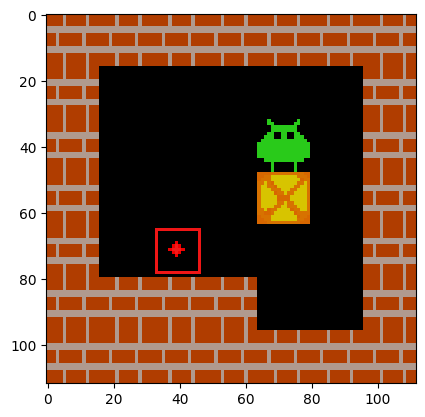

In [32]:
random.seed(2)
sok.reset()
screen = sok.render(mode='rgb_array')
plt.imshow(sok.render('rgb_array'))
observation, reward, done, _ = sok.step(1)
print_env_det(sok)

### EX1 - Video test

In [ ]:
env = sok
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

### EX2 - Video test

In [ ]:
env = sok_2
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

Since we ran on all of the steps as we did not have the ability to use Skip and Max like with the experiments receiving states as images, each experiment took a lot longer, hence, I checked only a few experiments.

Especially, after realizing fast convergence, it felt satisfactory to not run the large numbers of experiments like in the experiments receiving states as images

In [33]:
%%script echo skipping
experiment_id = 8
num_episodes = 500
optimizer_classes = ['AdamW', 'RMSprop']
lrs = [0.001, 0.0001]
epsilons = [1.0]
reward_manipulation_options = [True]
batch_sizes = [32]
epsilon_decay_factor = 0.98
epsilon_decay_exp = True
epsilon_decay_linear = False
memory_size = 50_000
seed_env = True

run_experiments(sok, num_episodes, experiment_id, optimizer_classes, lrs, epsilons, reward_manipulation_options,
                batch_sizes, epsilon_decay_factor, epsilon_decay_exp, epsilon_decay_linear, memory_size, seed_env)

skipping


To see all of the experiments run above:
[EX1 raw - DQN Experiments](https://dagshub.com/aviv.ples/sokoban-rl.mlflow/#/experiments/8)

### EX1 Solved - Raw States DQN Solution
Fastest convergence with the least amount of steps (5):

* optimizer = AdamW
* Learning Rate = 0.001
* Initial Epsilon = 1.0
* Epsilon Decay = True
* Reward Maniplation = True
* Batch Size = 32

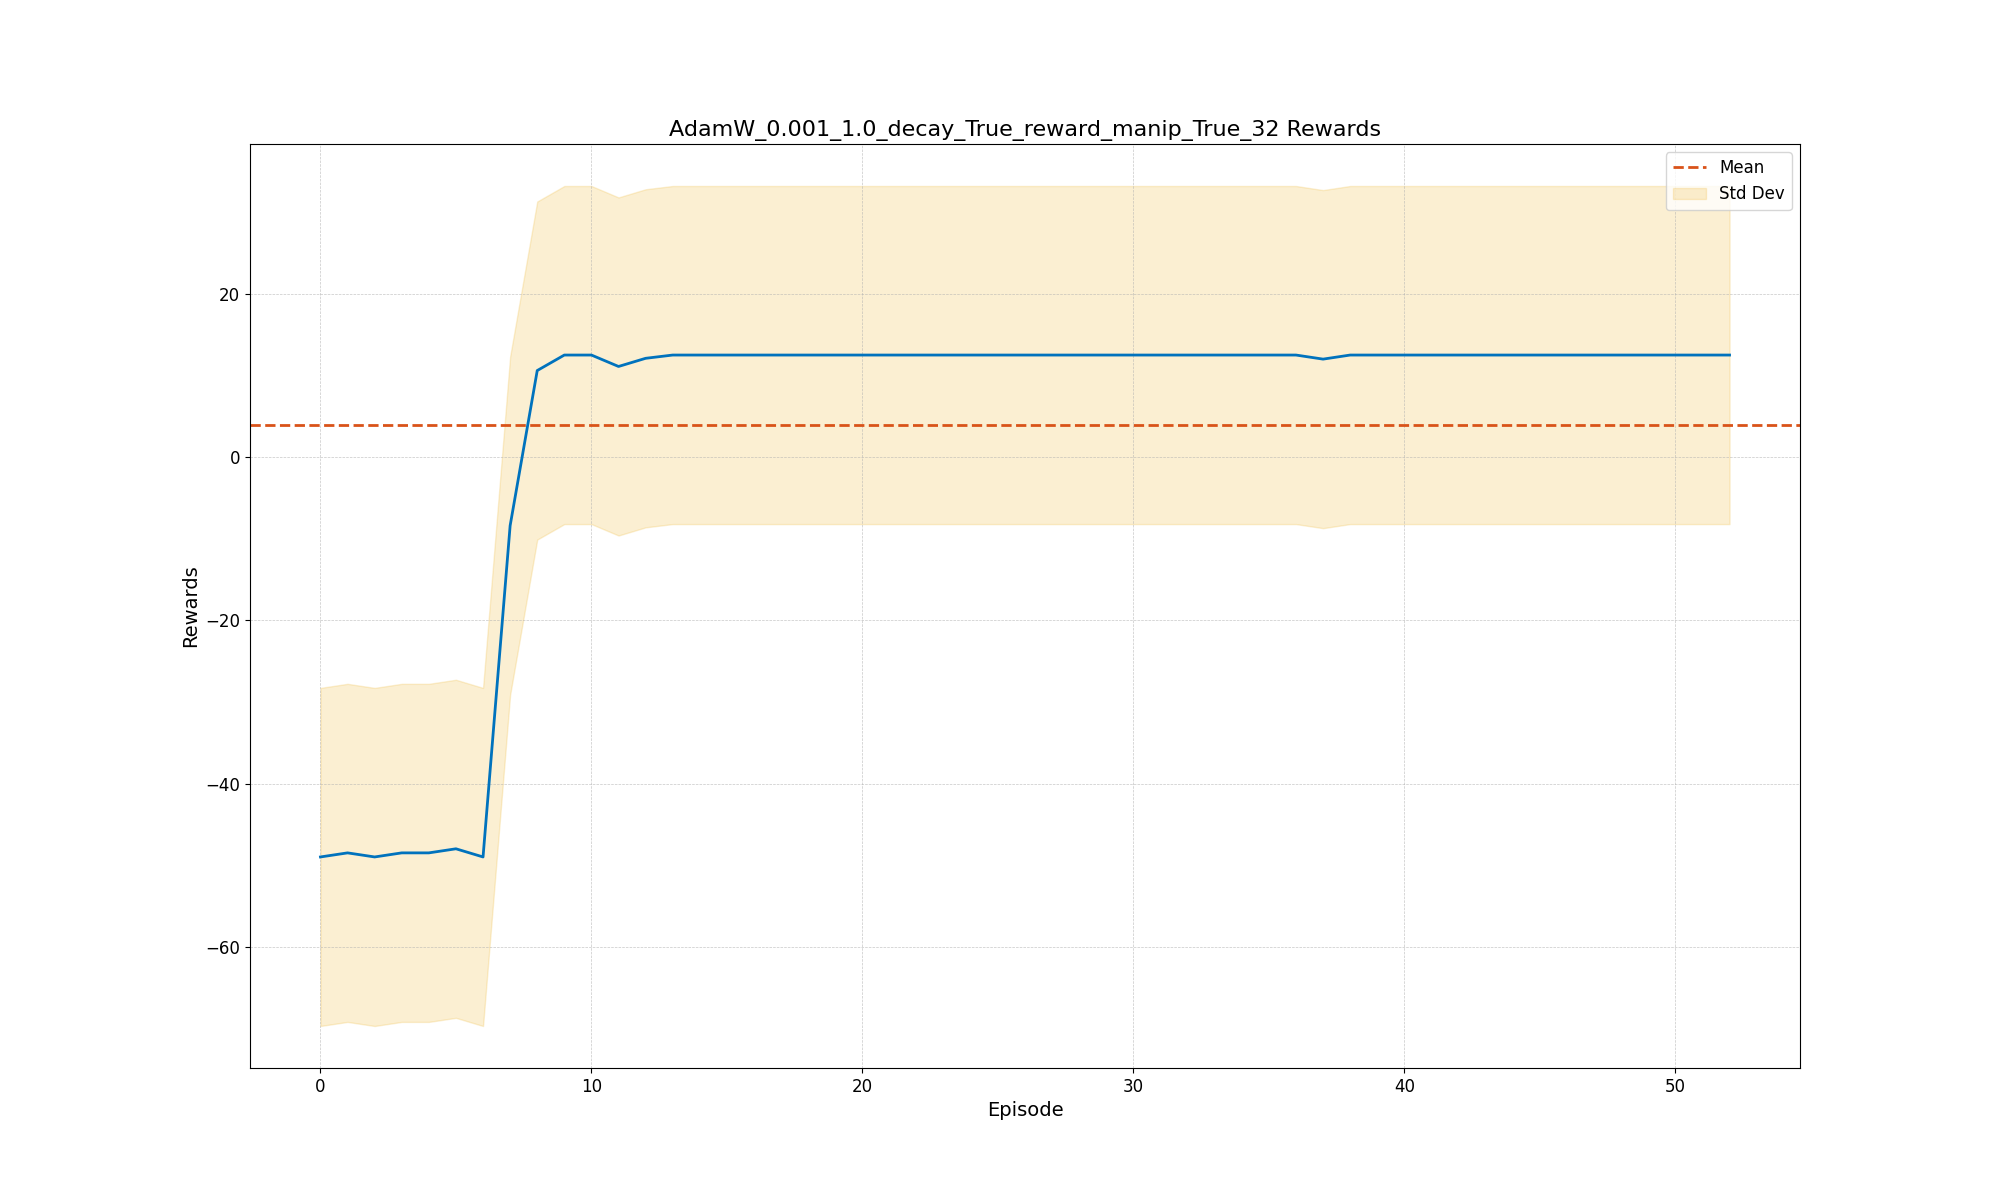

In [34]:
mlflow.artifacts.load_image('mlflow-artifacts:/7673d545b4c94ba2a01a83911bab8065/e190b5a861944bf2860ab4727542e819/artifacts/AdamW_0.001_1.0_decay_True_reward_manip_True_32_Rewards.png')

#### Half Way of Convergence

In [35]:
logged_model_ex1_dqn_half = 'runs:/e190b5a861944bf2860ab4727542e819/AdamW_0.001_1.0_decay_True_reward_manip_True_32_half'
model_ex1_dqn_half = mlflow.pytorch.load_model(logged_model_ex1_dqn_half, map_location=device)

2023/08/22 15:00:15 WARNING mlflow.pytorch: Stored model version '1.13.1+cu117' does not match installed PyTorch version '2.0.1+cu118'


In [39]:
video_filename = 'ex1_dqn_half.mp4'

create_model_attempt(sok, model_ex1_dqn_half, video_filename)
embed_mp4(video_filename)

#### Convergence

In [40]:
logged_model_ex1_dqn = 'runs:/e190b5a861944bf2860ab4727542e819/AdamW_0.001_1.0_decay_True_reward_manip_True_32'
model_ex1_dqn = mlflow.pytorch.load_model(logged_model_ex1_dqn, map_location=device)

2023/08/22 15:06:31 WARNING mlflow.pytorch: Stored model version '1.13.1+cu117' does not match installed PyTorch version '2.0.1+cu118'


In [41]:
video_filename = 'ex1_dqn.mp4'

create_model_attempt(sok, model_ex1_dqn, video_filename)
embed_mp4(video_filename)

## EX2 - PUSH & PULL - ONE BOX

In [42]:
#=============== DO NOT DELETE ===============
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[4 5]
Box location: (4, 4)


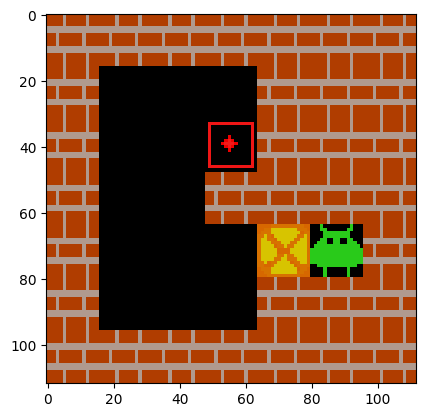

In [43]:
screen = sok_2.render(mode='rgb_array')
plt.imshow(sok_2.render('rgb_array'))
observation, reward, done, _ = sok_2.step(1)
print_env_det(sok_2)

### EX2 - Video test

In [ ]:
env = sok_2
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

In [45]:
%%script echo skipping
experiment_id = 9
num_episodes = 10_000
optimizer_classes = ['AdamW']
lrs = [0.001]
epsilons = [1.0]
reward_manipulation_options = [True]
batch_sizes = [128]
epsilon_decay_factor = 1_000
epsilon_decay_exp = False
epsilon_decay_linear = True
memory_size = 500_000
seed_env = False

run_experiments(sok_2, num_episodes, experiment_id, optimizer_classes, lrs, epsilons, reward_manipulation_options,
                batch_sizes, epsilon_decay_factor, epsilon_decay_exp, epsilon_decay_linear, memory_size, seed_env)

skipping


To see the experiment run above:
[EX2 raw - DQN Experiments](https://dagshub.com/aviv.ples/sokoban-rl.mlflow/#/experiments/9)

### EX2 trained model - Raw States DQN Solution

* optimizer = AdamW
* Learning Rate = 0.0001
* Initial Epsilon = 1.0
* Epsilon Decay = True
* Reward Maniplation = True
* Batch Size = 128

In [46]:
runID = 'b267fc5cacf847e99382da2aa95987b6'
metricKey = 'Sum of rewards'

client = mlflow.tracking.MlflowClient(tracking_uri=os.getenv('MLFLOW_TRACKING_URI'))

metrics = client.get_metric_history(runID, metricKey)

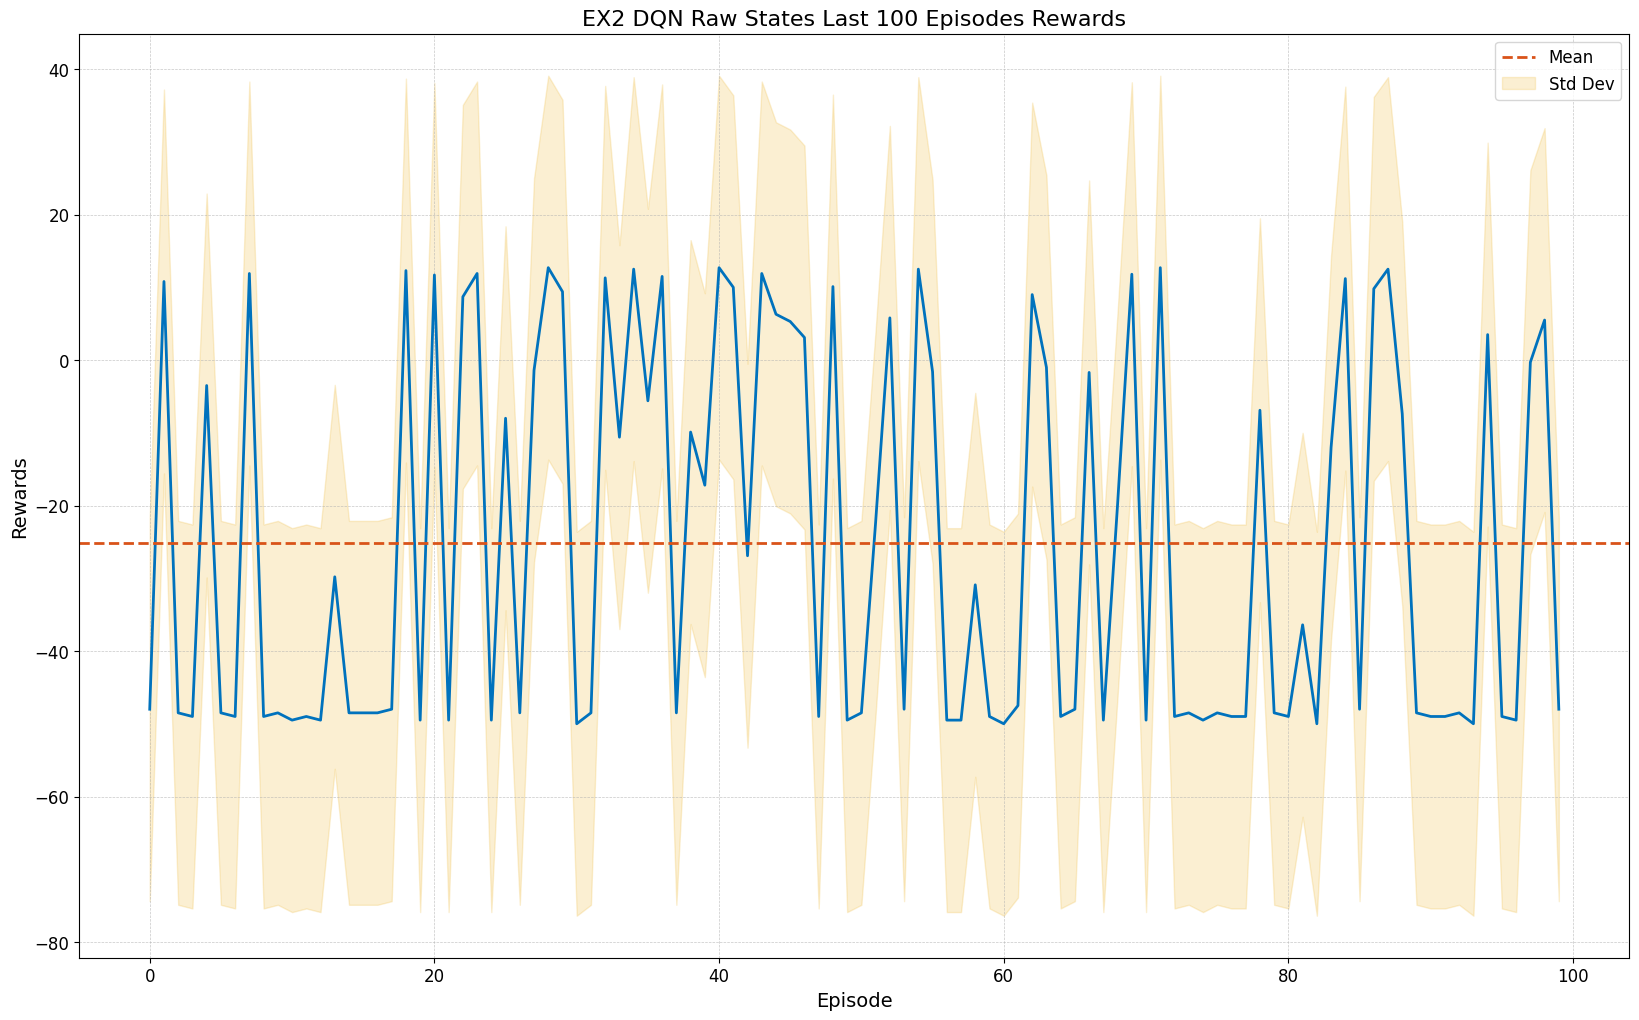

In [48]:
i = 5000
last_100 = [x.value for x in metrics[i-100:i]]
plot_results(last_100, add_mean_and_std=True, run_name='EX2 DQN Raw States Last 100 Episodes')

#### Checkpoint after 5000 episodes

In [66]:
logged_model_ex2_dqn = 'runs:/b267fc5cacf847e99382da2aa95987b6/AdamW_0.0001_1.0_decay_True_reward_manip_True_128_episode_5000'
model_ex2_dqn = mlflow.pytorch.load_model(logged_model_ex2_dqn, map_location=device)

2023/08/22 15:28:51 WARNING mlflow.pytorch: Stored model version '1.13.1+cu117' does not match installed PyTorch version '2.0.1+cu118'


In [67]:
won = 0
env_2 = sok_2

for i in range(100):
    state = env_2.reset(render_mode='raw')
    np.random.seed()
    start_time = time.time()
    done = False
    iter = 0
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

    while (iter < 20) or not done:
        time_passed = int(time.time() - start_time)
        if done or time_passed > 3:
            won += 1
            break
        iter += 1

        with torch.no_grad():
            action = model_ex2_dqn(state).max(1)[1].view(1, 1).item()

        # Take the step in the environment
        next_state, reward, done, info = env_2.step(action, observation_mode='raw')

        # Update the state
        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
    if i % 10 == 0 and i > 0:
        print(f"After {i} iterations, we have solved {won} enviornments.")

After 10 iterations, we have solved 3 enviornments.
After 20 iterations, we have solved 3 enviornments.
After 30 iterations, we have solved 6 enviornments.
After 40 iterations, we have solved 11 enviornments.
After 50 iterations, we have solved 15 enviornments.
After 60 iterations, we have solved 18 enviornments.
After 70 iterations, we have solved 22 enviornments.
After 80 iterations, we have solved 23 enviornments.
After 90 iterations, we have solved 26 enviornments.


In [68]:
print(f"The policy solved the game in {won}% of the times")

The policy solved the game in 29% of the times


## EX3 - PUSH & PULL - TWO BOXES

In [54]:
#=============== DO NOT DELETE ===============
sok_3 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=2 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[3 5]
Box location: (3, 4)


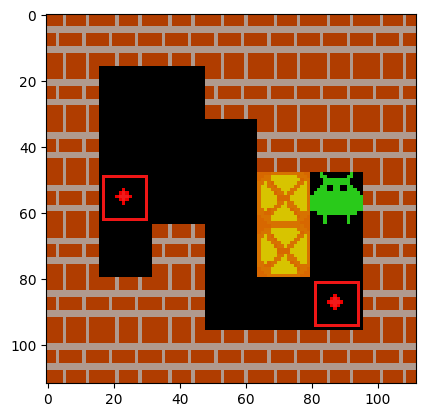

In [55]:
screen = sok_3.render(mode='rgb_array')
plt.imshow(sok_3.render('rgb_array'))
print_env_det(sok_3)

### EX3 - Video test

In [ ]:
env = sok_3
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

In [57]:
%%script echo skipping
experiment_id = 10
num_episodes = 10_000
optimizer_classes = ['AdamW']
lrs = [0.0001]
epsilons = [1.0]
reward_manipulation_options = [True]
batch_sizes = [128]
epsilon_decay_factor = 1_000
epsilon_decay_exp = False
epsilon_decay_linear = True
memory_size = 1_000_000
seed_env = False

run_experiments(sok_3, num_episodes, experiment_id, optimizer_classes, lrs, epsilons, reward_manipulation_options,
                batch_sizes, epsilon_decay_factor, epsilon_decay_exp, epsilon_decay_linear, memory_size, seed_env)

skipping


To see the experiment run above:
[EX3 raw - DQN Experiments](https://dagshub.com/aviv.ples/sokoban-rl.mlflow/#/experiments/10)

### EX3 trained model - Raw States DQN Solution

* optimizer = AdamW
* Learning Rate = 0.0001
* Initial Epsilon = 1.0
* Epsilon Decay = True
* Reward Maniplation = True
* Batch Size = 128

In [58]:
runID = '70f842787cd5490c9c141261cbf60964'
metricKey = 'Sum of rewards'

client = mlflow.tracking.MlflowClient(tracking_uri=os.getenv('MLFLOW_TRACKING_URI'))

metrics = client.get_metric_history(runID, metricKey)

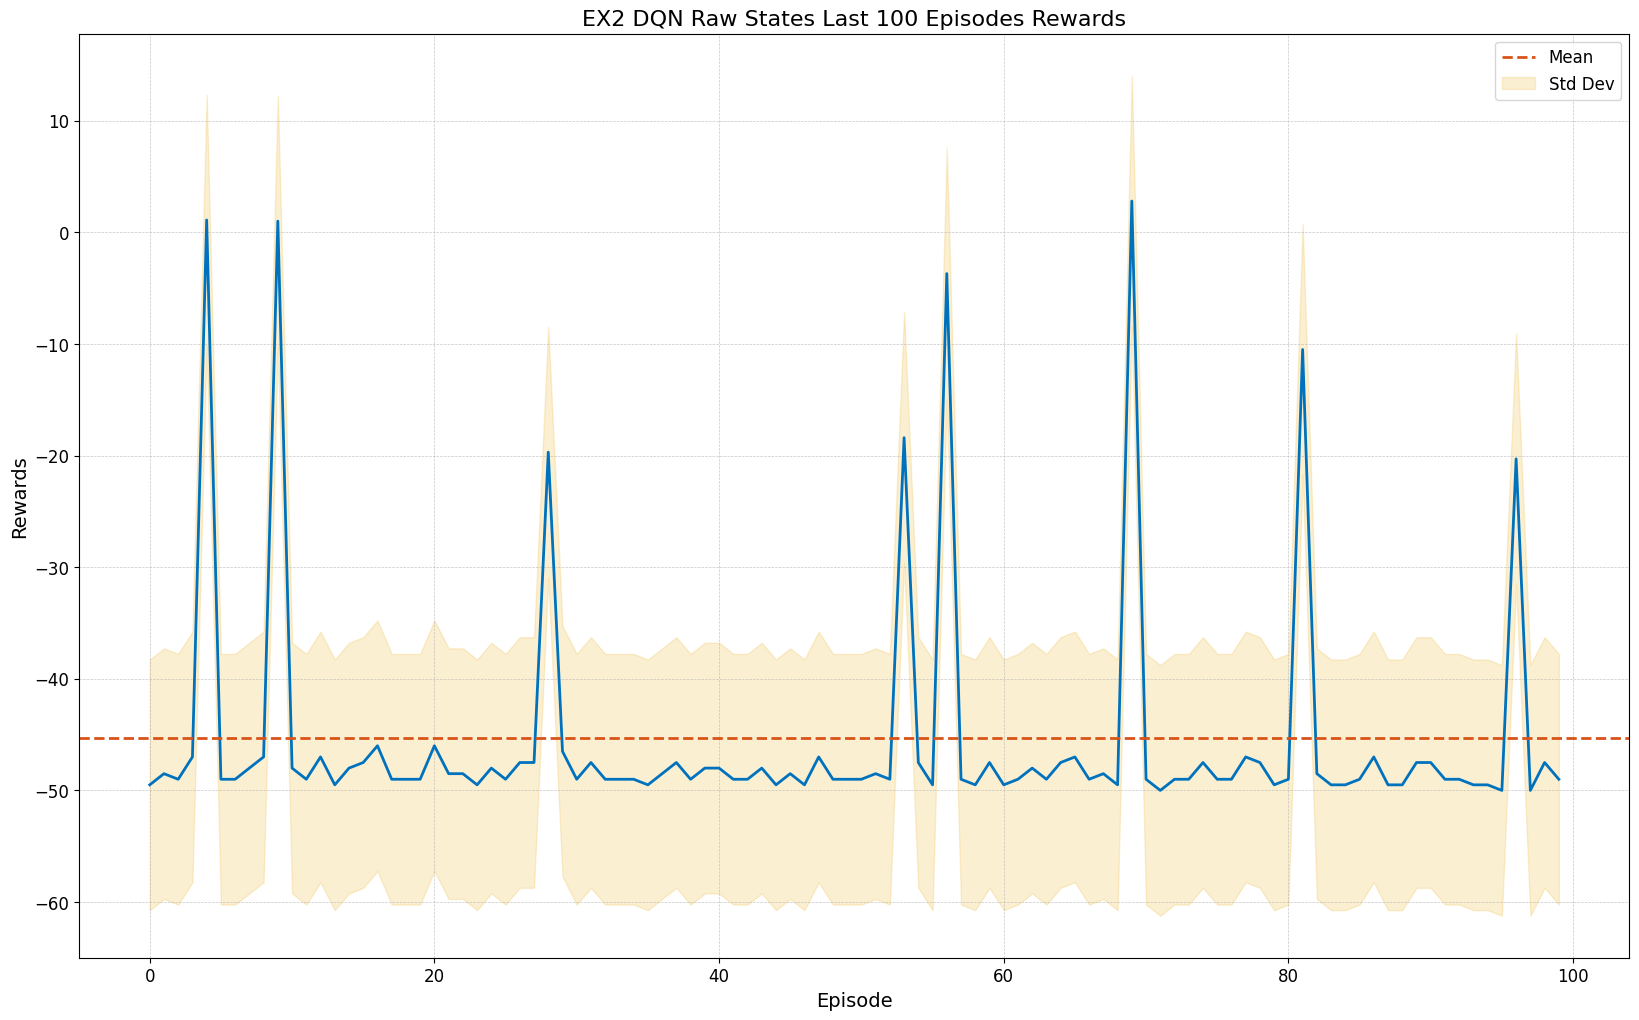

In [62]:
i = 3500
last_100 = [x.value for x in metrics[i-100:i]]
plot_results(last_100, add_mean_and_std=True, run_name='EX2 DQN Raw States Last 100 Episodes')

#### Checkpoint after 3500 episodes

In [63]:
logged_model_ex3_dqn = 'runs:/70f842787cd5490c9c141261cbf60964/AdamW_0.0001_1.0_decay_True_reward_manip_True_128_episode_3500'
model_ex3_dqn = mlflow.pytorch.load_model(logged_model_ex3_dqn, map_location=device)

2023/08/22 15:25:40 WARNING mlflow.pytorch: Stored model version '1.13.1+cu117' does not match installed PyTorch version '2.0.1+cu118'


In [64]:
won = 0
env_3 = sok_3

for i in range(100):
    state = env_3.reset(render_mode='raw')
    np.random.seed()
    start_time = time.time()
    done = False
    iter = 0
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

    while (iter < 20) or not done:
        time_passed = int(time.time() - start_time)
        if done or time_passed > 3:
            won += 1
            break
        iter += 1

        with torch.no_grad():
            action = model_ex3_dqn(state).max(1)[1].view(1, 1).item()

        # Take the step in the environment
        next_state, reward, done, info = env_3.step(action, observation_mode='raw')

        # Update the state
        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
    if i % 10 == 0 and i > 0:
        print(f"After {i} iterations, we have solved {won} enviornments.")

After 10 iterations, we have solved 0 enviornments.
After 20 iterations, we have solved 0 enviornments.
After 30 iterations, we have solved 0 enviornments.
After 40 iterations, we have solved 0 enviornments.
After 50 iterations, we have solved 0 enviornments.
After 60 iterations, we have solved 0 enviornments.
After 70 iterations, we have solved 0 enviornments.
After 80 iterations, we have solved 0 enviornments.
After 90 iterations, we have solved 0 enviornments.


In [65]:
print(f"The policy solved the game in {won}% of the times")

The policy solved the game in 0% of the times
